# Assignment 3
For this assignment we will work on the two-dimensional Ising chain in equilibrium with a heat bath at temperature $T$ and, possibly, in the presence of an external magnetic field $H$. We consider a square lattice with a side length of $L$ spins, with $N=L^2$ total spins in the system.
* Compute the average energy and the magnetization per spin of the 2D Ising model as a function of temperature and compare it with the analytic results. 
* Implement the calculation of the specific heat $C(T)$ and of the magnetic susceptibility $\chi(T)$ as done in the previous two assignments. Plot these functions for a system as a function of temperature, starting from $T=4$ and progressively decreasing the temperature down to $T=1.6$. 
* Set $T=T_C=2.269$, choose $L>128$. Obtain the magnetization for $H=0.01$, $0.02$, $0.04$, $0.08$, and $0.16$. Make a log-log plot of $m$ versus $H$ and estimate the critical exponent $\delta$.

Import useful modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background') # comment this out if you are not using the dark background

Define a few functions that will be used in the importance sampling Monte Carlo simulation.
- initial: performs the initialization of the system
- energy: compute the energy of the system
- flip_spin: flips a random spin in the system
- montecarlo: performs importance sampling Monte Carlo for a give number of steps

In [2]:
def initial(init,L):
    # initial configurations
    if init == 'up':
        s = np.ones((L,L))
    elif init == 'down':
        s = -np.ones((L,L))
    elif init == 'random':
        s = np.random.randint(0,2,(L,L))*2 -1
    else:
        print('wrong initial conditions')
    return s

In [3]:
def energy(s,J,B):
    # compute the configurational energy of the spin chain
    e = -J*np.sum(s*(np.roll(s,-1,axis=0)) + s*(np.roll(s,-1,axis=1))) - B*np.sum(s)
    return e

In [4]:
def flip_spin(s):	
    # generate spin chain by flipping one spin at a time
    indexi=np.random.randint(0,s.shape[0])
    indexj=np.random.randint(0,s.shape[1])
    s[indexi,indexj] *= -1
    return s

In [5]:
def montecarlo(s,J,B,T,L,n_steps):
    # importance sampling Monte Carlo algorithm
    #
    # initialize arrays to store results of simulation
    #
    energies = np.zeros(n_steps) # hold the total energy along the MC run
    magnetizations = np.zeros(n_steps) # hold the mean magnetization along the MC run
    microstates = np.zeros((n_steps,L,L)) # hold the actual states along the MC run
    #
    # set results of first configuration
    #
    energies[0]=energy(s,J,B)
    magnetizations[0]=np.sum(s)/L**2
    microstates[0, :, :]=s[:, :]
    #
    for i in range(1,n_steps):
        new_s = s.copy() # trial step is a copy of the current state
        new_s = flip_spin(new_s) # but with one random spin flipped
        #
        # Compute the Boltzmann factor 
        #
        new_energy=energy(new_s,J,B)
        old_energy=energies[i-1]
        boltzmann_factor = np.exp((old_energy-new_energy)/T)
        r = np.random.random()
        if r < min(1,boltzmann_factor) :
        # if the random number is lower than the boltzman factor
        # or the energy decreases, accept the trial move
            s = new_s.copy()
            energies[i]=new_energy
            magnetizations[i]=np.sum(s)/L**2
            microstates[i, :, :]=s[:, :]
        else:
        # otherwise, keep the old state
            energies[i]=old_energy
            magnetizations[i]=magnetizations[i-1]
            microstates[i, :, :]=s[:, :]
    return energies, magnetizations, microstates

Perform a trial run with fixed parameters, to check the results are correct and to see the effects of temperature, size, and magnetic field on the results.

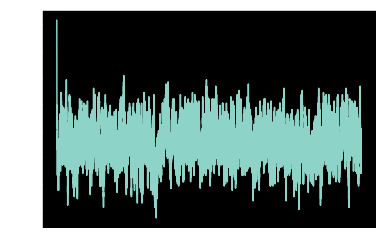

In [6]:
# 
# set simulation parameters
#
L = 20
J = 1.0 # Arbitrary units (kb=1.0)
B = 0.0
T = 4.0 # Temperature will be given in units of kb/J
n_steps = 1000*L**2
#
# perform the simulation
#
s = initial('random',L)
energies,magnetizations,microstates = montecarlo(s,J,B,T,L,n_steps)
#
# plot results
#
plt.plot(energies)
plt.show()

Here we plot the configurations at different steps

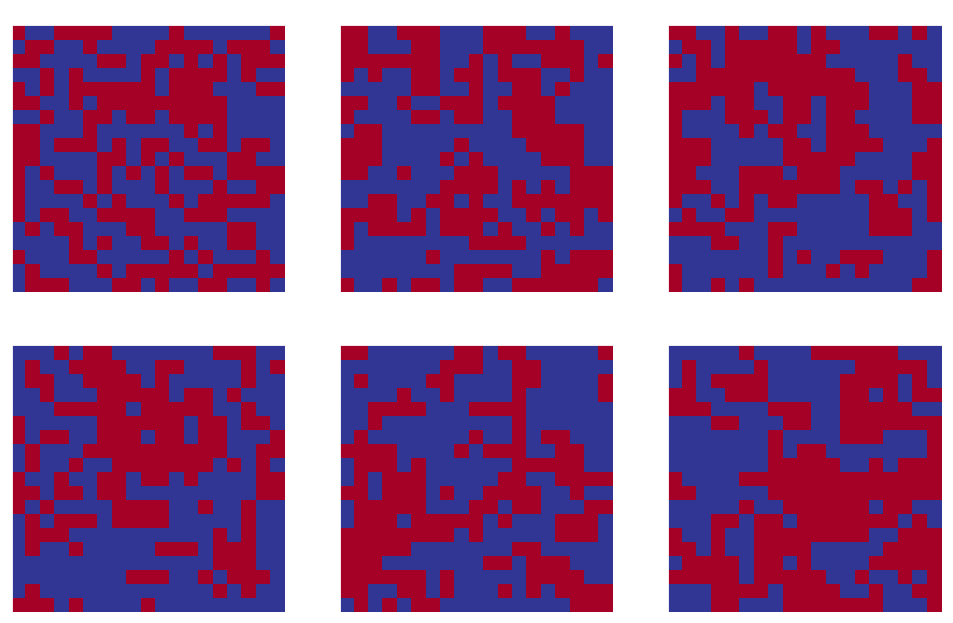

In [8]:
def configPlot(f, config, i, L, n):
    X, Y = np.meshgrid(range(L), range(L))
    sp = f.add_subplot(3, 3, n )  
    plt.setp(sp.get_yticklabels(), visible=False)
    plt.setp(sp.get_xticklabels(), visible=False)      
    plt.pcolormesh(X, Y, config, cmap=plt.cm.RdYlBu)
    plt.title('Time=%d'%i)
    plt.axis('tight')
f = plt.figure(figsize=(15, 15), dpi=80)   
configPlot(f, microstates[0*L**2,:,:], 0, L, 1)
configPlot(f, microstates[1*L**2,:,:], 1, L, 2)
configPlot(f, microstates[4*L**2,:,:], 4, L, 3)
configPlot(f, microstates[10*L**2,:,:], 10, L, 4)
configPlot(f, microstates[100*L**2,:,:], 100, L, 5)
configPlot(f, microstates[1000*L**2-1,:,:], 1000, L, 6)
plt.show()

Once we are confident about the parameters of the simulation, we can study the thermodynamic properties of the system as a function of temperature. Note that in order to converge these results, the simulations may need to be run for a longer number of steps.

In [9]:
# global simulation setup
#
L = 20
J = 1.0 # Arbitrary units (kb=1.0)
B = 0.0
T = 4.0
n_steps=10000 # NOTE: this number can be increased to improve the accuracy of the calculations
n_equilibration=2000 # NOTE: this number needs to be changed, use the number that you estimated previously
#
# setting up the range of temperatures
#
n_temperatures=12
T_max = 4.
T_min = 0.4
#
# initializing the arrays that will hold the results
#
temperatures=np.zeros(n_temperatures)
mean_energies=np.zeros(n_temperatures)
mean_magnetizations=np.zeros(n_temperatures)
#
s = initial('random',L)
for i,T in enumerate(np.linspace(T_max,T_min,n_temperatures)):
    energies,magnetizations,_ = montecarlo(s,J,B,T,L,n_steps)
    temperatures[i]=T
    mean_energies[i]=np.average(energies[n_equilibration:])
    mean_magnetizations[i]=np.average(magnetizations[n_equilibration:])

Plot the results as a function of temperature

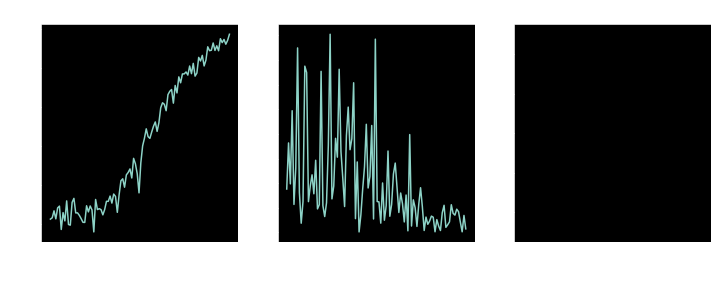

In [10]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].set_title('Energy',fontsize=16)
ax[0].plot(temperatures,mean_energies)
ax[1].set_title('Magnetization',fontsize=16)
ax[1].set_xlabel('Temperature',fontsize=16)
ax[1].plot(temperatures,abs(mean_magnetizations))
ax[2].set_title('Specific Heat',fontsize=16)
ax[2].plot()
plt.show()

Now we set the temperature to the Curie temperature (the one corresponding to the phase transition) and study the effect of the external field. 

In [19]:
# global simulation setup
#
L = 128
J = 1.0 # Arbitrary units (kb=1.0)
T = 2.269
n_steps=100000 # NOTE: this number can be increased to improve the accuracy of the calculations
n_equilibration=2000 # NOTE: this number needs to be changed, use the number that you estimated previously
#
# setting up the range of temperatures
#
fields=np.array([0.01, 0.02, 0.04, 0.08, 0.16])
#
# initializing the arrays that will hold the results
#
mean_magnetizations=np.zeros(len(fields))
#
s = initial('random',L)
for i,B in enumerate(fields):
    energies,magnetizations,_ = montecarlo(s,J,B,T,L,n_steps)
    mean_magnetizations[i]=np.average(magnetizations[n_equilibration:])

Plot the magnetization as a function of magnetic field. In a log-log plot, we can evaluate the critical exponent from the slope of the data.

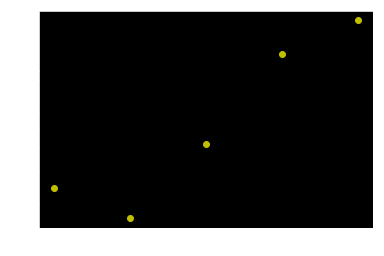

In [24]:
plt.loglog(fields,mean_magnetizations,'yo')
plt.show()